In [3]:
## IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

In [4]:
## READING IN DATASET FROM ADJUSTED SQL FILE

df_original = pd.read_csv("MTablePythonShort.csv")

#REMOVING COLUMNS THAT ARE UNIMPORTANT
df = df_original.drop(["npi", "nppes_provider_last_org_name", "nppes_provider_first_name", "nppes_provider_mi", "nppes_credentials",  "nppes_provider_street1", "nppes_provider_street2", "nppes_provider_city", "nppes_provider_zip", "nppes_provider_state", "nppes_provider_country", "place_of_service", "hcpcs_description", "hcpcs_drug_indicator", "hcpcs_code"], axis = 1)

#REMOVING FIRST ROW OF DATASET AS IT HAS UNUSABLE VALUES
df = df.iloc[1:]

/Users/ArshyaSrinivas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


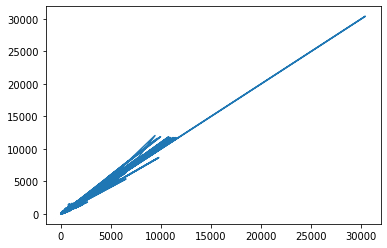

In [42]:
## EDA: CREATING SCATTER PLOTS OF MEDICARE PAYMENTS
x = df.loc[:,"average_Medicare_payment_amt"]
y = df.loc[:,"average_Medicare_standard_amt"]
plt.plot(x,y)
plt.show()

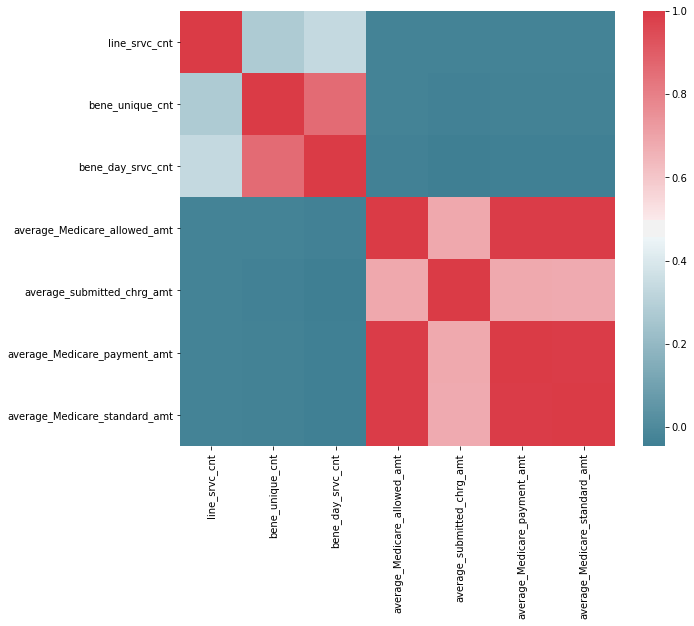

In [43]:
## EDA: CREATING HEATMAPS OF RELATIONSHIPS

df_floats = df.loc[:,"line_srvc_cnt":"average_Medicare_standard_amt"]

f, ax = plt.subplots(figsize=(10, 8))
df_corr = df_floats.corr()
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

Text(0, 0.5, 'Count of provider types')

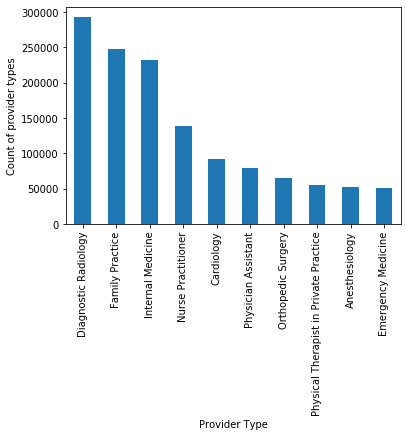

In [46]:
## EDA: CREATING BAR PLOTS FOR DIFFERENT PROVIDER TYPES

df["provider_type"].value_counts().plot(kind = "bar")
plt.xlabel("Provider Type")
plt.ylabel("Count of provider types")

In [5]:
## ONE HOT ENCODING

#Gender
gender_ohe = pd.get_dummies(df['nppes_provider_gender'],prefix='gender')

#Participation
part_ohe = pd.get_dummies(df['medicare_participation_indicator'],prefix='participation')

#nppes_entity_code
entity_ohe = pd.get_dummies(df['nppes_entity_code'],prefix='entity')

#Provider type
provider_ohe = pd.get_dummies(df['provider_type'],prefix='provider')

In [6]:
## CREATING A FINAL DATABASE

df_final = pd.concat([df, gender_ohe, part_ohe, entity_ohe, provider_ohe], axis = 1)
df_final.drop(["nppes_provider_gender"], axis = 1, inplace = True)
df_final.drop(["medicare_participation_indicator"], axis = 1, inplace = True)
df_final.drop(["nppes_entity_code"], axis = 1, inplace = True)
df_final.drop(["provider_type"], axis = 1, inplace = True)

In [7]:
## CREATING DATABASES SEPARATED BY GENDER

# Female database
df_female = df_final.loc[df_final["gender_F"] == 1]
df_female.drop(["gender_F"], axis = 1, inplace = True)
df_female.drop(["gender_M"], axis = 1, inplace = True)

# Male database
df_male = df_final.loc[df_final["gender_M"] == 1]
df_male.drop(["gender_F"], axis = 1, inplace = True)
df_male.drop(["gender_M"], axis = 1, inplace = True)


/Users/ArshyaSrinivas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [17]:
#KMEANS CLUSTERING PREPROCESSING FOR FEMALE PROVIDERS

scalar_female = preprocessing.StandardScaler().fit(df_female)
dfNorm_female = scalar.transform(df_female)

In [18]:
## DETERMINING MAXIMUM NUMBER OF CLUSTERS FOR FEMALES USING SSE

maxClusters = 30
sse_female = []

for nClusters in range(2,maxClusters):
    kmeans_female = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm_female)
    sse_female.append(kmeans_female.inertia_)

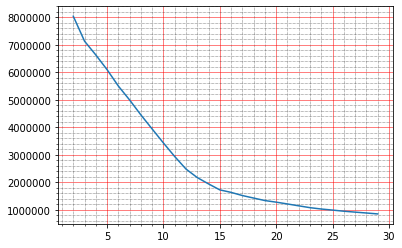

In [27]:
## PLOTTING THE SSE CURVE

fig, ax = plt.subplots()
plt.plot(range(2,maxClusters),sse_female)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [28]:
## CALCULATING KMEANS FOR THE FEMALE DATASET

kmeans_female = KMeans(n_clusters = 12, random_state = 0).fit(dfNorm_female)

In [41]:
## ANALYZING CLUSTERING RESULTS FOR THE FEMALE DATASET

data_female = pd.concat([df_female,pd.DataFrame(kmeans_female.labels_,columns=["Cluster"])],axis=1)
data_female['Cluster'].value_counts()
data_female.groupby('Cluster').mean()

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,participation_N,participation_Y,entity_I,...,provider_Anesthesiology,provider_Cardiology,provider_Diagnostic Radiology,provider_Emergency Medicine,provider_Family Practice,provider_Internal Medicine,provider_Nurse Practitioner,provider_Orthopedic Surgery,provider_Physical Therapist in Private Practice,provider_Physician Assistant
Cluster,,,,,,,,,,,,,,,,,,,,,
0.0,110.967432,59.190624,93.753120,65.311891,214.987650,49.963668,51.144424,0.000000,1.000000,1.0,...,0.023347,0.031729,0.106861,0.028687,0.198820,0.169513,0.256628,0.007079,0.066625,0.110711
1.0,111.788896,56.891753,90.782955,65.785604,214.651244,50.213240,51.454981,0.000352,0.999648,1.0,...,0.022957,0.025598,0.106795,0.030881,0.183413,0.160830,0.275901,0.003830,0.068518,0.121277
2.0,104.458067,56.137791,88.334597,65.561458,230.158790,50.257894,51.362529,0.000000,1.000000,1.0,...,0.029778,0.025447,0.115864,0.023281,0.179210,0.181375,0.257986,0.000541,0.070926,0.115593
3.0,118.587956,55.676920,89.470500,64.627197,218.629416,49.430196,50.563785,0.000079,0.999921,1.0,...,0.023671,0.019417,0.112170,0.027097,0.203742,0.154510,0.266325,0.003348,0.067901,0.121820
4.0,87.612903,55.419355,79.838710,42.041884,234.915363,30.643988,29.363679,0.000000,1.000000,1.0,...,0.000000,0.000000,0.225806,0.000000,0.032258,0.032258,0.419355,0.000000,0.096774,0.193548
5.0,100.691740,53.851032,86.778761,63.487740,216.631087,48.885632,49.444261,0.000000,1.000000,1.0,...,0.014749,0.011799,0.061947,0.020649,0.178466,0.188791,0.356932,0.001475,0.041298,0.123894
6.0,123.770999,59.321490,93.593299,64.622556,210.054003,49.713379,50.855862,0.000000,1.000000,1.0,...,0.022241,0.014443,0.111207,0.038995,0.190930,0.182842,0.257366,0.004622,0.067880,0.109474
7.0,113.081632,57.475053,91.209263,64.578020,209.022360,49.320332,50.446442,0.000070,0.999930,1.0,...,0.022737,0.025368,0.107158,0.027789,0.181439,0.166351,0.283965,0.004807,0.067579,0.112807
8.0,111.013243,56.147614,90.230965,63.424340,200.342242,48.477027,49.628690,0.000000,1.000000,1.0,...,0.018980,0.024892,0.106508,0.023861,0.183351,0.179610,0.271529,0.004718,0.067299,0.119252


In [30]:
## KMEANS CLUSTERING PREPROCESSING FOR MALE PROVIDERS

scalar_male = preprocessing.StandardScaler().fit(df_male)
dfNorm_male = scalar.transform(df_male)

In [31]:
## DETERMINING MAXIMUM NUMBER OF CLUSTERS FOR MALES USING SSE

maxClusters = 30
sse_male = []

for nClusters in range(2,maxClusters):
    kmeans_male = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm_male)
    sse_male.append(kmeans_male.inertia_)

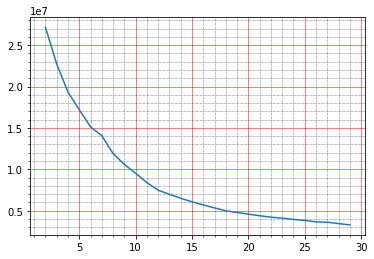

In [33]:
## PLOTTING THE SSE CURVE

fig, ax = plt.subplots()
plt.plot(range(2,maxClusters),sse_male)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [34]:
## CALCULATING KMEANS FOR THE MALE DATASET

kmeans_male = KMeans(n_clusters = 12, random_state = 0).fit(dfNorm_male)

In [40]:
## ANALYZING CLUSTERING RESULTS FOR THE FEMALE DATASET

data_male = pd.concat([df_male,pd.DataFrame(kmeans_male.labels_,columns=["Cluster"])],axis=1)
data_male['Cluster'].value_counts()
data_male.groupby('Cluster').mean()

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,participation_N,participation_Y,entity_I,...,provider_Anesthesiology,provider_Cardiology,provider_Diagnostic Radiology,provider_Emergency Medicine,provider_Family Practice,provider_Internal Medicine,provider_Nurse Practitioner,provider_Orthopedic Surgery,provider_Physical Therapist in Private Practice,provider_Physician Assistant
Cluster,,,,,,,,,,,,,,,,,,,,,
0.0,127.299094,69.839101,100.198161,80.057294,311.464531,61.329670,62.991097,0.000027,0.999973,1.0,...,0.047622,0.094647,0.283886,0.044367,0.199246,0.186771,0.012502,0.073494,0.025763,0.031703
1.0,125.869831,68.321029,98.568948,80.982183,316.038365,62.051769,63.793785,0.000028,0.999972,1.0,...,0.049063,0.097417,0.290089,0.043932,0.190426,0.183955,0.012662,0.072921,0.027458,0.032077
2.0,125.205859,68.470989,98.513982,79.419355,309.030416,60.826328,62.414250,0.000064,0.999936,1.0,...,0.047879,0.094887,0.290739,0.042858,0.194060,0.185850,0.013418,0.072936,0.027165,0.030207
3.0,131.017883,68.433665,98.787127,79.705241,306.729239,60.948514,62.656691,0.000072,0.999928,1.0,...,0.050136,0.104107,0.280318,0.041428,0.192768,0.184131,0.011253,0.077982,0.025767,0.032110
4.0,131.556772,70.560705,100.906611,77.820861,312.310953,59.531981,61.108153,0.000000,1.000000,1.0,...,0.049439,0.095617,0.294858,0.050429,0.181991,0.181289,0.011472,0.071847,0.030744,0.032313
5.0,135.342189,68.160893,97.856961,79.347323,279.500615,60.887440,62.504564,0.000213,0.999787,1.0,...,0.047184,0.096918,0.282891,0.051010,0.201488,0.187248,0.014878,0.068013,0.022954,0.027418
6.0,124.565110,68.007249,98.232793,79.370579,310.027058,60.821997,62.518731,0.000070,0.999930,1.0,...,0.049669,0.095006,0.286873,0.044435,0.194033,0.185009,0.011279,0.074954,0.027040,0.031702
7.0,122.061948,69.308578,99.593688,78.713245,306.775634,60.438188,61.902781,0.000175,0.999825,1.0,...,0.052138,0.102646,0.293884,0.044141,0.188229,0.180639,0.010366,0.067376,0.029427,0.031155
8.0,77.666667,63.119048,76.071429,48.094105,195.375403,37.580076,36.607568,0.000000,1.000000,1.0,...,0.047619,0.095238,0.595238,0.000000,0.166667,0.047619,0.000000,0.047619,0.000000,0.000000
